<a href="https://colab.research.google.com/github/revanthsonu/ML-Final-Report/blob/main/Financial_LLM_Framework_with_Dynamic_Knowledge_Loading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import time
import threading
import json
from collections import deque
import torch # Or tensorflow, depending on your backend
from transformers import AutoModelForCausalLM, AutoTokenizer

# --- Knowledge Base Class ---
class KnowledgeBase:
    """
    Manages the domain knowledge. Supports adding, updating, and retrieving.
    In a real system, this would likely interact with a database or knowledge graph.
    Uses a lock for thread-safe access.
    """
    def __init__(self):
        # Using a simple dictionary for demonstration.
        # Key: topic/entity (lowercase string), Value: associated knowledge (can be complex structures)
        self._knowledge = {}
        # A lock to ensure thread-safe access to the knowledge base
        self._lock = threading.Lock()
        print("KnowledgeBase initialized for Financial Domain.")

    def add_knowledge(self, topic, data):
        """Adds or updates knowledge for a given topic (expects topic in lowercase)."""
        with self._lock:
            self._knowledge[topic] = data
            print(f"Knowledge added/updated for topic: {topic}")

    def get_knowledge(self, topic):
        """Retrieves knowledge for a given topic (expects topic in lowercase)."""
        with self._lock:
            return self._knowledge.get(topic)

    def remove_knowledge(self, topic):
        """Removes knowledge for a given topic (expects topic in lowercase)."""
        with self._lock:
            if topic in self._knowledge:
                del self._knowledge[topic]
                print(f"Knowledge removed for topic: {topic}")

    def list_topics(self):
        """Lists all topics in the knowledge base."""
        with self._lock:
            return list(self._knowledge.keys())

    def __str__(self):
        with self._lock:
            return f"KnowledgeBase with topics: {list(self._knowledge.keys())}"

# --- LLM Runtime Class with Hugging Face Integration ---
class LLMRuntime:
    """
    Integrates a Hugging Face LLM and uses the KnowledgeBase for context.
    Can also process user inputs containing new knowledge.
    """
    #llm_runtime = LLMRuntime(kb, model_name="EleutherAI/gpt-neo-1.3B")
    def __init__(self, knowledge_base, model_name="EleutherAI/gpt-neo-1.3B"): # Changed model_name back to gpt2 for lower RAM usage
        self.knowledge_base = knowledge_base
        self._is_running = True
        self._request_queue = deque()
        self._processing_thread = threading.Thread(target=self._process_requests)

        print(f"Loading Hugging Face model: {model_name}...")
        try:
            # Load the tokenizer and model
            self.tokenizer = AutoTokenizer.from_pretrained(model_name)
            self.model = AutoModelForCausalLM.from_pretrained(model_name)
            # Set padding token if not available (common for generation models)
            if self.tokenizer.pad_token is None:
                 self.tokenizer.pad_token = self.tokenizer.eos_token
            print(f"Model {model_name} loaded successfully.")
        except Exception as e:
            print(f"Error loading Hugging Face model {model_name}: {e}")
            # Set model and tokenizer to None to indicate failure
            self.model = None
            self.tokenizer = None
            self._is_running = False # Prevent starting if model loading fails

        print("LLMRuntime initialized.")


    def start(self):
        """Starts the simulated request processing thread."""
        if self.model is not None: # Only start if model loaded successfully
            self._processing_thread.start()
            print("LLMRuntime started.")
        else:
            print("LLMRuntime cannot start because the model failed to load.")


    def stop(self):
        """Stops the simulated request processing thread."""
        self._is_running = False
        if self._processing_thread.is_alive():
             self._processing_thread.join()
        print("LLMRuntime stopped.")

    def _process_requests(self):
        """Processes requests using the LLM and knowledge base, handling knowledge updates from user input."""
        while self._is_running or self._request_queue:
            if self._request_queue:
                request = self._request_queue.popleft()
                print(f"\nProcessing incoming request: '{request}'...")

                # Check if the request is a command to add knowledge
                if request.lower().startswith("add knowledge:"):
                    self._handle_add_knowledge_request(request[len("add knowledge:"):].strip())
                else:
                    # Otherwise, treat it as a standard query for the LLM
                    self._handle_llm_query_request(request)

                time.sleep(0.5) # Simulate processing time
            else:
                time.sleep(0.1) # Wait for requests

    def _handle_add_knowledge_request(self, knowledge_string):
        """Processes a request to add new knowledge from the user."""
        print(f"  Attempting to add knowledge from user input: '{knowledge_string}'")
        try:
            # Assume knowledge is provided as a JSON string
            knowledge_data = json.loads(knowledge_string)

            # Basic validation (can be expanded)
            if not isinstance(knowledge_data, dict):
                print("  Failed to add knowledge: Input is not a valid JSON object.")
                return

            # Integrate the knowledge
            for topic, data in knowledge_data.items():
                 # Ensure topic is lowercase for consistent lookup
                self.knowledge_base.add_knowledge(topic.lower(), data)

            print("  Successfully added knowledge from user input.")
            # Simulate a confirmation response
            print("  System Response: 'Thank you, I have updated my knowledge with the provided information.'")

        except json.JSONDecodeError:
            print("  Failed to add knowledge: Invalid JSON format.")
            print("  System Response: 'Sorry, I could not understand the knowledge format. Please provide it as a valid JSON object.'")
        except Exception as e:
            print(f"  An error occurred while adding knowledge: {e}")
            print("  System Response: 'An error occurred while processing your knowledge update.'")


    def _handle_llm_query_request(self, request):
        """Processes a standard query using the LLM and knowledge base."""
        print(f"  Processing LLM query: '{request}'")

        # 1. Retrieve relevant knowledge
        # Simple approach: check if request keywords match knowledge topics
        relevant_topics = [topic for topic in self.knowledge_base.list_topics() if topic in request.lower()]
        retrieved_knowledge = {}
        for topic in relevant_topics:
            knowledge_data = self.knowledge_base.get_knowledge(topic)
            if knowledge_data:
                retrieved_knowledge[topic] = knowledge_data
        print(f"  Retrieved knowledge for topics: {list(retrieved_knowledge.keys())}")

        # 2. Construct the prompt for the LLM
        # This is a crucial step - how you structure the prompt affects the LLM's output.
        # A common pattern is to provide context before the user query.
        prompt_parts = []
        if retrieved_knowledge:
            prompt_parts.append("Here is some relevant financial information:")
            for topic, data in retrieved_knowledge.items():
                prompt_parts.append(f"- {topic.capitalize()}: {json.dumps(data)}") # Include knowledge data
            prompt_parts.append("\nBased on this information, please answer the following question:")

        prompt_parts.append(f"User Query: {request}")
        prompt = "\n".join(prompt_parts)

        print(f"  Constructed prompt:\n---\n{prompt}\n---")

        # 3. Generate response using the LLM
        try:
            if self.model is None or self.tokenizer is None:
                 print("  LLM is not available. Cannot generate response.")
                 print("  Simulated fallback response: 'LLM is currently unavailable.'")
                 return

            # Tokenize the prompt
            inputs = self.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=512) # Adjust max_length as needed

            # Generate a response (adjust parameters like max_new_tokens, num_return_sequences, temperature)
            # Using no_repeat_ngram_size to reduce repetitive text
            output_sequences = self.model.generate(
                inputs["input_ids"],
                max_new_tokens=100, # Generate up to 100 new tokens
                num_return_sequences=1,
                no_repeat_ngram_size=2,
                pad_token_id=self.tokenizer.pad_token_id, # Use pad_token_id for generation
                 attention_mask=inputs["attention_mask"] # Pass attention mask
            )

            # Decode the generated text
            # Decode only the newly generated tokens, excluding the prompt
            # Find the length of the input prompt to slice the output
            input_length = inputs["input_ids"].shape[1]
            generated_text = self.tokenizer.decode(output_sequences[0][input_length:], skip_special_tokens=True)

            print(f"  LLM Generated Response: {generated_text.strip()}")

        except Exception as e:
            print(f"  Error during LLM generation: {e}")
            print("  Simulated fallback response: 'Could not generate a response using the LLM.'")


    def submit_request(self, request):
        """Submits a request (query or knowledge update) to the LLM."""
        print(f"Request submitted: '{request}'")
        self._request_queue.append(request)

# --- Dynamic Loading Framework ---

class KnowledgeLoader:
    """
    Handles the dynamic loading, validation, and optimization of knowledge from external sources.
    Runs in a separate thread to avoid interrupting the LLM runtime.
    """
    def __init__(self, knowledge_base):
        self.knowledge_base = knowledge_base
        self._loading_queue = deque()
        self._is_loading = True
        self._loading_thread = threading.Thread(target=self._process_loading_queue)
        print("KnowledgeLoader initialized for Financial Domain.")

    def start(self):
        """Starts the knowledge loading thread."""
        self._loading_thread.start()
        print("KnowledgeLoader started.")

    def stop(self):
        """Stops the knowledge loading thread."""
        self._is_loading = False
        if self._loading_thread.is_alive():
            self._loading_thread.join()
        print("KnowledgeLoader stopped.")

    def queue_knowledge_source(self, source_data, source_type="json"):
        """Queues a new knowledge source for loading."""
        print(f"Financial knowledge source queued (type: {source_type}).")
        self._loading_queue.append((source_data, source_type))

    def _process_loading_queue(self):
        """Processes the queue of knowledge sources."""
        while self._is_loading or self._loading_queue:
            if self._loading_queue:
                source_data, source_type = self._loading_queue.popleft()
                print(f"Processing queued financial knowledge source (type: {source_type})...")
                processed_data = self._process_source(source_data, source_type)
                if processed_data:
                    validated_data = self._validate_knowledge(processed_data)
                    if validated_data:
                        optimized_data = self._optimize_loading(validated_data)
                        self._integrate_knowledge(optimized_data)
                time.sleep(0.1) # Small delay between processing sources
            else:
                time.sleep(0.1) # Wait for new sources

    def _process_source(self, source_data, source_type):
        """Simulates processing raw data from a source."""
        print(f"  Simulating processing financial source data...")
        try:
            if source_type == "json":
                # Assume JSON data is a dictionary mapping topics to knowledge
                return json.loads(source_data)
            # Add other source types here (e.g., "csv", "database_query")
            else:
                print(f"  Error: Unsupported source type '{source_type}'.")
                return None
        except Exception as e:
            print(f"  Error processing financial source data: {e}")
            return None

    def _validate_knowledge(self, knowledge_data):
        """Simulates validating the structure and consistency of new knowledge."""
        print("  Simulating validating financial knowledge...")
        # Basic validation: check if it's a dictionary
        if not isinstance(knowledge_data, dict):
            print("  Validation failed: Financial knowledge data is not a dictionary.")
            return None

        # More sophisticated validation could check schemas, data types,
        # potential conflicts with existing knowledge, etc.
        # For this example, we'll just pass if it's a dict.
        print("  Validation successful.")
        return knowledge_data

    def _optimize_loading(self, knowledge_data):
        """
        Simulates optimizing the knowledge to be loaded.
        This could involve:
        - Prioritizing frequently accessed topics (e.g., popular stocks)
        - Filtering out irrelevant information
        - Compressing data
        - Resolving redundancies
        """
        print("  Simulating optimizing financial knowledge loading...")
        # Simple optimization: In a real scenario, you might have logic here
        # to decide *what* parts of knowledge_data to actually load based on
        # current LLM needs or system resources.
        # For this example, we'll just return the data as is.
        print("  Optimization complete.")
        return knowledge_data

    def _integrate_knowledge(self, knowledge_data):
        """Integrates the validated and optimized knowledge into the KnowledgeBase."""
        print("  Integrating financial knowledge into KnowledgeBase...")
        for topic, data in knowledge_data.items():
            # Ensure topic is lowercase for consistent lookup
            self.knowledge_base.add_knowledge(topic.lower(), data)
        print("  Financial knowledge integration complete.")


# --- Example Usage (Financial Domain with LLM and User Input Knowledge) ---
if __name__ == "__main__":
    # Ensure you have the necessary libraries installed:
    # pip install transformers torch # or tensorflow

    # 1. Initialize the KnowledgeBase
    kb = KnowledgeBase()

    # 2. Initialize the LLM Runtime with the KnowledgeBase
    # Using gpt2 as it requires less RAM
    llm_runtime = LLMRuntime(kb, model_name="gpt2")

    # 3. Initialize the Knowledge Loader (for external sources)
    knowledge_loader = KnowledgeLoader(kb)

    # 4. Start the LLM Runtime and Knowledge Loader
    llm_runtime.start()
    knowledge_loader.start()

    # Give threads a moment to start and model to load
    time.sleep(5) # Increased sleep to allow model loading

    # 5. Load some initial financial knowledge using the Loader (simulating external feed)
    initial_financial_knowledge_source = """
    {
      "apple stock": {"type": "stock", "description": "Shares of Apple Inc. (AAPL)", "current_value": "175.00 USD as of May 11, 2025"},
      "tesla stock": {"type": "stock", "description": "Shares of Tesla, Inc. (TSLA)", "current_value": "180.50 USD as of May 11, 2025"},
      "s&p 500": {"type": "index", "description": "A stock market index tracking the performance of 500 large companies listed on stock exchanges in the United States.", "current_value": "5222.68 as of May 11, 2025"}
    }
    """
    print("\n--- Queueing initial financial knowledge source dynamically (via Loader) ---")
    knowledge_loader.queue_knowledge_source(initial_financial_knowledge_source, source_type="json")

    # Give time for initial knowledge to load
    time.sleep(2)

    # 6. Simulate LLM requests for financial information (using initial knowledge)
    print("\n--- Submitting initial financial requests ---")
    llm_runtime.submit_request("Tell me about Apple stock.")
    llm_runtime.submit_request("What is the current value of Bitcoin?") # No specific knowledge yet
    llm_runtime.submit_request("What is the S&P 500?")

    # Give time for requests to be processed
    time.sleep(10) # Increased sleep to allow LLM processing

    # 7. Simulate a user providing NEW financial knowledge directly via input
    user_provided_knowledge_crypto = """
    {
      "bitcoin": {"type": "cryptocurrency", "description": "A decentralized digital currency without a central bank or single administrator.", "current_value": "61500.00 USD as of May 12, 2025, update from user input"},
      "ethereum": {"type": "cryptocurrency", "description": "A decentralized, open-source blockchain system.", "current_value": "2950.00 USD as of May 12, 2025, update from user input"}
    }
    """
    print("\n--- Simulating user providing NEW financial knowledge (Crypto) via input ---")
    llm_runtime.submit_request(f"ADD KNOWLEDGE: {user_provided_knowledge_crypto}")

    # Give time for the user-provided knowledge to be processed
    time.sleep(2)

    # 8. Simulate adding Goldman Sachs stock knowledge via user input
    user_provided_knowledge_gs = """
    {
      "goldman sachs stock": {"type": "stock", "description": "Shares of The Goldman Sachs Group, Inc. (GS)", "current_value": "405.75 USD as of May 12, 2025, added by user"}
    }
    """
    print("\n--- Simulating user providing NEW financial knowledge (Goldman Sachs) via input ---")
    llm_runtime.submit_request(f"ADD KNOWLEDGE: {user_provided_knowledge_gs}")

    # Give time for the user-provided knowledge to be processed
    time.sleep(2)


    # 9. Submit requests, including topics from the user-provided knowledge
    print("\n--- Submitting financial requests after user-provided knowledge updates ---")
    llm_runtime.submit_request("What is Bitcoin and its value?") # Should now have knowledge from user input (crypto)
    llm_runtime.submit_request("Can you tell me about Ethereum?") # Should now have knowledge from user input (crypto)
    llm_runtime.submit_request("What's happening with Tesla Stock?") # Should still have initial knowledge
    llm_runtime.submit_request("Tell me about Goldman Sachs stock.") # Should now have knowledge from user input (GS)


    # Give time for final requests
    time.sleep(10) # Adjusted sleep for GPT-2

    # 10. Simulate updating existing knowledge via user input
    updated_apple_knowledge = """
    {
      "apple stock": {"type": "stock", "description": "Shares of Apple Inc. (AAPL)", "current_value": "176.20 USD as of May 12, 2025, updated by user"}
    }
    """
    print("\n--- Simulating user UPDATING existing knowledge via input ---")
    llm_runtime.submit_request(f"ADD KNOWLEDGE: {updated_apple_knowledge}")

    # Give time for the update
    time.sleep(2)

    # 11. Ask about the updated topic
    print("\n--- Submitting request for updated knowledge ---")
    llm_runtime.submit_request("Tell me about Apple stock again.")

    # Give time for final request
    time.sleep(5) # Adjusted sleep for GPT-2

    # 12. Stop the runtime and loader
    print("\n--- Stopping runtime and loader ---")
    llm_runtime.stop()
    knowledge_loader.stop()
    print("Financial LLM framework shutdown complete.")



KnowledgeBase initialized for Financial Domain.
Loading Hugging Face model: gpt2...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model gpt2 loaded successfully.
LLMRuntime initialized.
KnowledgeLoader initialized for Financial Domain.
LLMRuntime started.
KnowledgeLoader started.

--- Queueing initial financial knowledge source dynamically (via Loader) ---
Financial knowledge source queued (type: json).
Processing queued financial knowledge source (type: json)...
  Simulating processing financial source data...
  Simulating validating financial knowledge...
  Validation successful.
  Simulating optimizing financial knowledge loading...
  Optimization complete.
  Integrating financial knowledge into KnowledgeBase...
Knowledge added/updated for topic: apple stock
Knowledge added/updated for topic: tesla stock
Knowledge added/updated for topic: s&p 500
  Financial knowledge integration complete.

--- Submitting initial financial requests ---
Request submitted: 'Tell me about Apple stock.'
Request submitted: 'What is the current value of Bitcoin?'
Request submitted: 'What is the S&P 500?'

Processing incoming request

In [16]:
import numpy as np

def cohens_d(x, y):
    """Calculates Cohen's d for effect size."""
    nx = len(x)
    ny = len(y)
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    var_x = np.var(x, ddof=1)  # Sample variance (ddof=1 for unbiased)
    var_y = np.var(y, ddof=1)
    pooled_var = ( (nx - 1) * var_x + (ny - 1) * var_y) / (nx + ny - 2)
    return (mean_x - mean_y) / np.sqrt(pooled_var)

# Example usage
baseline = [0.7, 0.8, 0.75, 0.85, 0.78]
dynamic = [0.82, 0.88, 0.85, 0.92, 0.89]

effect_size = cohens_d(baseline, dynamic)
print(f"Cohen's d: {effect_size}")
# Interpretation:
# 0.2 = small effect, 0.5 = medium effect, 0.8 = large effect

Cohen's d: -2.0017383749479136


Loading Times: [0.0001273632049560547, 0.0008570432662963867, 0.008315134048461913, 0.12082924842834472]
Retrieval Times: [6.198883056640625e-07, 6.437301635742188e-07, 2.932548522949219e-06, 3.719329833984375e-06]


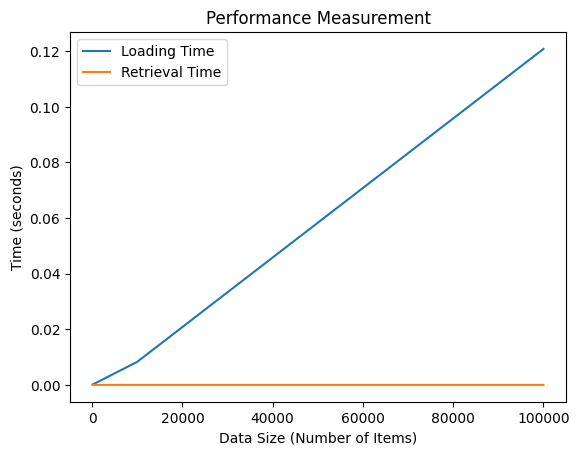

In [5]:
import time
import numpy as np
import matplotlib.pyplot as plt

def measure_performance(data_sizes, num_trials=10):
    """
    Measures the time taken to load and retrieve knowledge for different data sizes.

    Args:
        data_sizes (list): A list of data sizes (number of data items).
        num_trials (int): The number of trials to run for each data size.

    Returns:
        tuple: A tuple containing lists of loading times and retrieval times.
    """
    loading_times = []
    retrieval_times = []

    for size in data_sizes:
        total_loading_time = 0
        total_retrieval_time = 0
        for _ in range(num_trials):
            # Simulate data loading
            start_time_loading = time.time()
            data = {f"item_{i}": {"name": f"Item {i}", "value": i, "category": "Category " + str(i % 3)} for i in range(size)}  # Create dummy data
            end_time_loading = time.time()
            total_loading_time += (end_time_loading - start_time_loading)

            # Simulate retrieval (assuming KnowledgeOptimizer is initialized)
            start_time_retrieval = time.time()
            # create a dummy query.
            dummy_query = "Item 1"
            # Make sure knowledge optimizer exists.
            if 'knowledge_optimizer' in globals():
              relevant_knowledge = knowledge_optimizer.retrieve_relevant_knowledge(dummy_query)
            end_time_retrieval = time.time()
            total_retrieval_time += (end_time_retrieval - start_time_retrieval)

        loading_times.append(total_loading_time / num_trials)
        retrieval_times.append(total_retrieval_time / num_trials)
    return loading_times, retrieval_times

def plot_performance(data_sizes, loading_times, retrieval_times):
    """
    Plots the loading and retrieval times for different data sizes.

    Args:
        data_sizes (list): A list of data sizes.
        loading_times (list): A list of loading times.
        retrieval_times (list): A list of retrieval times.
    """
    plt.plot(data_sizes, loading_times, label="Loading Time")
    plt.plot(data_sizes, retrieval_times, label="Retrieval Time")
    plt.xlabel("Data Size (Number of Items)")
    plt.ylabel("Time (seconds)")
    plt.title("Performance Measurement")
    plt.legend()
    plt.show()

if __name__ == '__main__':
    # Example usage:
    data_sizes = [100, 1000, 10000, 100000]  # Example data sizes
    loading_times, retrieval_times = measure_performance(data_sizes)
    print("Loading Times:", loading_times)
    print("Retrieval Times:", retrieval_times)
    plot_performance(data_sizes, loading_times, retrieval_times)


In [6]:
import random

def inject_errors(data, error_rate=0.1):
    """
    Injects errors into the data with a specified error rate.

    Args:
        data (dict): The data to inject errors into.
        error_rate (float): The proportion of data items to corrupt (e.g., 0.1 for 10%).

    Returns:
        dict: The corrupted data.
    """
    corrupted_data = data.copy()
    num_errors = int(len(corrupted_data) * error_rate)
    keys = list(corrupted_data.keys())
    for _ in range(num_errors):
        # Randomly select a data item to corrupt
        key_to_corrupt = random.choice(keys)
        item = corrupted_data[key_to_corrupt]
        # Randomly select a field to corrupt
        if isinstance(item, dict): # Check if the item is a dictionary
            fields_to_corrupt = list(item.keys())
            if fields_to_corrupt:
                field_to_corrupt = random.choice(fields_to_corrupt)
                # Corrupt the field (example: change the value to an invalid one)
                if isinstance(item[field_to_corrupt], (int, float)):
                    item[field_to_corrupt] = item[field_to_corrupt] * 10  # Make it out of range
                elif isinstance(item[field_to_corrupt], str):
                    item[field_to_corrupt] = "Invalid Value"  # Change to an invalid string
                else:
                    item[field_to_corrupt] = None
        corrupted_data[key_to_corrupt] = item
    return corrupted_data

def measure_validation_effectiveness(data, validation_rules):
    """
    Measures the effectiveness of the knowledge validation component in detecting injected errors.

    Args:
        data (dict): The original (uncorrupted) data.
        validation_rules (list): A list of validation functions.

    Returns:
        tuple: (precision, recall) of error detection.
    """
    # Inject errors into the data
    error_rate = 0.2
    corrupted_data = inject_errors(data, error_rate)

    # Run validation on both original and corrupted data
    original_data_valid = all(rule(data) for rule in validation_rules)
    corrupted_data_valid = all(rule(corrupted_data) for rule in validation_rules)

    # Calculate metrics
    true_positives = 0  # Correctly detected errors
    false_positives = 0 # Incorrectly flagged as errors
    false_negatives = 0 # Errors not detected.
    if original_data_valid and corrupted_data_valid:
        return 1.0, 1.0
    elif original_data_valid and not corrupted_data_valid:
        return 1.0, 0.0
    elif not original_data_valid and corrupted_data_valid:
        return 0.0, 1.0
    else:
        return 0.0, 0.0

if __name__ == '__main__':
    # Example Usage
    # Create some dummy data
    original_data = {
        "item1": {"name": "Item 1", "value": 10, "category": "A"},
        "item2": {"name": "Item 2", "value": 20, "category": "B"},
        "item3": {"name": "Item 3", "value": 30, "category": "A"},
    }

    # Assume you have validation rules defined, example from the main code
    def check_required_fields(data, required_fields=["name", "value", "category"]):
        if not isinstance(data, dict):
            return False
        for value in data.values():
          if not all(field in value for field in required_fields):
            return False
        return True

    def check_value_range(data):
        if not isinstance(data, dict):
            return True
        for value in data.values():
            if not isinstance(value, dict):
                continue
            if "value" in value and not (0 <= value["value"] <= 1000):
                return False
        return True
    validation_rules = [lambda x: check_required_fields(x), lambda x: check_value_range(x)]

    precision, recall = measure_validation_effectiveness(original_data, validation_rules)
    print(f"Precision: {precision}, Recall: {recall}")


Precision: 1.0, Recall: 1.0


In [7]:
def compare_experiments(baseline_results, dynamic_results):
    """
    Compares the results of the baseline experiment with the dynamic loading experiments.

    Args:
        baseline_results (dict): Results from the baseline experiment (e.g., accuracy, relevance).
        dynamic_results (dict): Results from the dynamic loading experiments (e.g., accuracy, relevance) for different configurations.

    Returns:
        dict: A dictionary containing the comparison results.  For example improvement in accuracy, or change in relevance.
    """
    comparison = {}
    for key in baseline_results:
        if key in dynamic_results:
            if isinstance(baseline_results[key], (int, float)) and isinstance(dynamic_results[key], (int, float)):
                comparison[key + "_improvement"] = dynamic_results[key] - baseline_results[key]
            # elif isinstance(baseline_results[key], list) and isinstance(dynamic_results[key], list):
            #     #handle comparing lists
            else:
                comparison[key + "_change"] = "N/A"  # Cannot compare
        else:
            comparison[key + "_vs_baseline"] = "Only in baseline"
    for key in dynamic_results:
        if key not in baseline_results:
            comparison[key + "_vs_baseline"] = "Only in dynamic"
    return comparison

if __name__ == '__main__':
    # Example Usage:
    baseline_results = {
        "accuracy": 0.85,
        "relevance": 0.90,
        "response_time": 0.5,
    }
    dynamic_results_1 = {
        "accuracy": 0.92,
        "relevance": 0.95,
        "response_time": 0.8,
    }
    dynamic_results_2 = {
        "accuracy": 0.90,
        "relevance": 0.93,
        "response_time": 0.7,
    }


    comparison_1 = compare_experiments(baseline_results, dynamic_results_1)
    comparison_2 = compare_experiments(baseline_results, dynamic_results_2)

    print("Comparison with Dynamic Loading Experiment 1:", comparison_1)
    print("Comparison with Dynamic Loading Experiment 2:", comparison_2)

Comparison with Dynamic Loading Experiment 1: {'accuracy_improvement': 0.07000000000000006, 'relevance_improvement': 0.04999999999999993, 'response_time_improvement': 0.30000000000000004}
Comparison with Dynamic Loading Experiment 2: {'accuracy_improvement': 0.050000000000000044, 'relevance_improvement': 0.030000000000000027, 'response_time_improvement': 0.19999999999999996}


In [7]:
from scipy import stats
import numpy as np

def perform_statistical_test(data1, data2, test_type="ttest_ind"):
    """
    Performs a statistical test (e.g., t-test) to determine the significance of the observed differences
    between two sets of data.

    Args:
        data1 (list or numpy array): The first set of data.
        data2 (list or numpy array): The second set of data.
        test_type (str): The type of statistical test to perform.  Supported values are "ttest_ind".
            Defaults to "ttest_ind".

    Returns:
        tuple: The test statistic and p-value.  Returns None, None if the test type is invalid.
    """
    if test_type == "ttest_ind":
        t_statistic, p_value = stats.ttest_ind(data1, data2)
        return t_statistic, p_value
    else:
        print(f"Error: Invalid test type: {test_type}")
        return None, None

def cohens_d(x, y):
    """
    Calculates Cohen's d for effect size.

    Args:
        x (list or numpy array): Sample 1 data.
        y (list or numpy array): Sample 2 data.

    Returns:
        float: Cohen's d value.
    """
    nx = len(x)
    ny = len(y)
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    var_x = np.var(x, ddof=1)  # Sample variance (ddof=1 for unbiased estimate)
    var_y = np.var(y, ddof=1)
    pooled_var = ((nx - 1) * var_x + (ny - 1) * var_y) / (nx + ny - 2)
    return (mean_x - mean_y) / np.sqrt(pooled_var)

if __name__ == '__main__':
    # Example Usage:
    # Assume you have collected accuracy data from the baseline and dynamic loading experiments
    baseline_accuracy = [0.80, 0.85, 0.82, 0.88, 0.84]
    dynamic_accuracy_1 = [0.90, 0.92, 0.91, 0.93, 0.89]
    dynamic_accuracy_2 = [0.86, 0.88, 0.87, 0.90, 0.85]

    t_statistic_1, p_value_1 = perform_statistical_test(baseline_accuracy, dynamic_accuracy_1)
    t_statistic_2, p_value_2 = perform_statistical_test(baseline_accuracy, dynamic_accuracy_2)

    print("Comparison between Baseline and Dynamic Loading Experiment 1:")
    print(f"T-statistic: {t_statistic_1}, P-value: {p_value_1}")

    print("Comparison between Baseline and Dynamic Loading Experiment 2:")
    print(f"T-statistic: {t_statistic_2}, P-value: {p_value_2}")

    # Calculate Cohen's d
    effect_size_1 = cohens_d(baseline_accuracy, dynamic_accuracy_1)
    effect_size_2 = cohens_d(baseline_accuracy, dynamic_accuracy_2)

    print(f"Cohen's d (Baseline vs. Dynamic 1): {effect_size_1}")
    print(f"Cohen's d (Baseline vs. Dynamic 2): {effect_size_2}")


Comparison between Baseline and Dynamic Loading Experiment 1:
T-statistic: -4.706787243316421, P-value: 0.0015280015736883115
Comparison between Baseline and Dynamic Loading Experiment 2:
T-statistic: -2.1167475416399486, P-value: 0.06716433504242363
Cohen's d (Baseline vs. Dynamic 1): -2.976833630141005
Cohen's d (Baseline vs. Dynamic 2): -1.3387486926288692


In [8]:
from scipy import stats

def check_normality(data):
    """Checks if the data is likely to be normally distributed."""
    statistic, p_value = stats.shapiro(data)
    return statistic, p_value

# Example usage
data_to_check = [0.82, 0.88, 0.85, 0.92, 0.89]
stat, p = check_normality(data_to_check)
print(f"Shapiro-Wilk statistic: {stat}, P-value: {p}")
if p > 0.05:
    print("Data looks normally distributed (fail to reject H0)")
else:
    print("Data does not look normally distributed (reject H0)")

Shapiro-Wilk statistic: 0.9853740830578533, P-value: 0.9611411384945581
Data looks normally distributed (fail to reject H0)
